# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://docs.langchain.com/oss/python/concepts/memory#profile) or [collection](https://docs.langchain.com/oss/python/concepts/memory#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to pull together the pieces we've learned to build an agent with long-term memory.

Our agent, `task_mAIstro`, will help us manage a ToDo list! 

The chatbots we built previously *always* reflected on the conversation and saved memories. 

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

The chatbots we built previously always saved one type of memory, a profile or a collection. 

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

This allows the user to update their preferences for creating ToDo items. 

In [1]:
%%capture --no-stderr
%pip install -U langgraph git+https://github.com/QuinRiva/trustcall.git langchain_core

In [2]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
_set_env("GOOGLE_API_KEY")

## Visibility into Trustcall updates

Trustcall creates and updates JSON schemas.

What if we want visibility into the *specific changes* made by Trustcall?

For example, we saw before that Trustcall has some of its own tools to:

* Self-correct from validation failures -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* Update existing documents -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

Visibility into these tools can be useful for the agent we're going to build.

Below, we'll show how to do this!

In [10]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

We can add a [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners) <!-- broken, but cannot find better linke --> to the Trustcall extractor.

This will pass runs from the extractor's execution to a class, `Spy`, that we will define.

Our `Spy` class will extract information about what tool calls were made by Trustcall.

In [11]:
from trustcall import create_extractor
from langchain_google_genai import ChatGoogleGenerativeAI

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [12]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [13]:
result

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'Memory', 'arguments': '{"content": "User had a nice bike ride in San Francisco this morning."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='lc_run--de7e23ef-f10c-427f-af49-78ca6644335f-0', tool_calls=[{'name': 'Memory', 'args': {'content': 'User had a nice bike ride in San Francisco this morning.'}, 'id': '7626601b-3ee6-4239-a477-df10bdfd6ec2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 88, 'total_tokens': 171, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 65}})],
 'responses': [Memory(content='User had a nice bike ride in San Francisco this morning.')],
 'response_metadata': [{'id': '7626601b-3ee6-4239-a477-df10bdfd6ec2',
   'name': 'Memory',
   'usage_metadata': {'input_tokens': 83,
    'output_tokens': 88,
    't

In [14]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (7626601b-3ee6-4239-a477-df10bdfd6ec2)
 Call ID: 7626601b-3ee6-4239-a477-df10bdfd6ec2
  Args:
    content: User had a nice bike ride in San Francisco this morning.


In [15]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='User had a nice bike ride in San Francisco this morning.'


In [16]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': '7626601b-3ee6-4239-a477-df10bdfd6ec2', 'name': 'Memory', 'usage_metadata': {'input_tokens': 83, 'output_tokens': 88, 'total_tokens': 171, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 65}}}


In [18]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'User had a nice bike ride in San Francisco this morning.'})]

In [19]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke(
    {
        "messages": updated_conversation, 
        "existing": existing_memories
    }
)

In [22]:
result

{'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {'12d06e14-281d-4afc-bb37-60f94d7cb0a1': '0'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='lc_run--aaa42fee-1ace-4117-bc02-44fdc5d3269c-0', tool_calls=[{'name': 'Memory', 'args': {'content': 'User had a nice bike ride in San Francisco this morning. User went to Tartine and ate a croissant. User was thinking about Japan, and going back this winter.'}, 'id': '12d06e14-281d-4afc-bb37-60f94d7cb0a1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 739, 'output_tokens': 434, 'total_tokens': 1173, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 288}})],
 'responses': [Memory(content='User had a nice bike ride in San Francisco this morning. User went to Tartine and ate a croissant. User was thinking about Japan, and going back this winter.')],
 'response_metadata'

In [20]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': '12d06e14-281d-4afc-bb37-60f94d7cb0a1', 'name': 'Memory', 'usage_metadata': {'input_tokens': 739, 'output_tokens': 434, 'total_tokens': 1173, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 288}}, 'json_doc_id': '0'}


In [23]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (12d06e14-281d-4afc-bb37-60f94d7cb0a1)
 Call ID: 12d06e14-281d-4afc-bb37-60f94d7cb0a1
  Args:
    content: User had a nice bike ride in San Francisco this morning. User went to Tartine and ate a croissant. User was thinking about Japan, and going back this winter.


In [24]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='User had a nice bike ride in San Francisco this morning. User went to Tartine and ate a croissant. User was thinking about Japan, and going back this winter.'


In [25]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'planned_edits': 'The user provided new information about their day and future plans. I need to update the existing Memory instance to include these new details. I will replace the content field with a combined string that includes the previous memory and the new information about eating a croissant and thinking about Japan. I am referencing the `content` field of the `Memory` schema.',
    'json_doc_id': '0',
    'patches': [{'op': 'replace',
      'value': 'User had a nice bike ride in San Francisco this morning. User went to Tartine and ate a croissant. User was thinking about Japan, and going back this winter.',
      'path': '/content'}]},
   'id': '12d06e14-281d-4afc-bb37-60f94d7cb0a1',
   'type': 'tool_call'}]]

In [47]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            args = call.get("args", None)

            if call['name'] == 'PatchDoc':
                
                json_doc_id = args.get("json_doc_id", "")
                planned_edits = args.get("planned_edits", "")
                patches = args.get("patches")
                print("type of patches: ", type(patches), patches)
                if isinstance(patches, list):
                    value = patches[0]['value']
                elif isinstance(patches, dict):
                    value = patches['value']
                else:
                    ValueError(f"wrong type of patches: {type(patches)}\n{patches}")
                changes.append({
                    'type': 'update',
                    'doc_id': json_doc_id,
                    'planned_edits': planned_edits,
                    'value': value
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': args
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

type of patches:  <class 'list'> [{'op': 'replace', 'value': 'User had a nice bike ride in San Francisco this morning. User went to Tartine and ate a croissant. User was thinking about Japan, and going back this winter.', 'path': '/content'}]
Document 0 updated:
Plan: The user provided new information about their day and future plans. I need to update the existing Memory instance to include these new details. I will replace the content field with a combined string that includes the previous memory and the new information about eating a croissant and thinking about Japan. I am referencing the `content` field of the `Memory` schema.
Added content: User had a nice bike ride in San Francisco this morning. User went to Tartine and ate a croissant. User was thinking about Japan, and going back this winter.


In [48]:
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'planned_edits': 'The user provided new information about their day and future plans. I need to update the existing Memory instance to include these new details. I will replace the content field with a combined string that includes the previous memory and the new information about eating a croissant and thinking about Japan. I am referencing the `content` field of the `Memory` schema.',
    'json_doc_id': '0',
    'patches': [{'op': 'replace',
      'value': 'User had a nice bike ride in San Francisco this morning. User went to Tartine and ate a croissant. User was thinking about Japan, and going back this winter.',
      'path': '/content'}]},
   'id': '12d06e14-281d-4afc-bb37-60f94d7cb0a1',
   'type': 'tool_call'}]]

## Creating an agent

There are many different agent architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://docs.langchain.com/oss/python/langgraph/workflows-agents#agents) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory: 

(a) Create or update a user `profile` with general user information 

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [36]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

In [37]:
_set_env("GOOGLE_API_KEY")

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

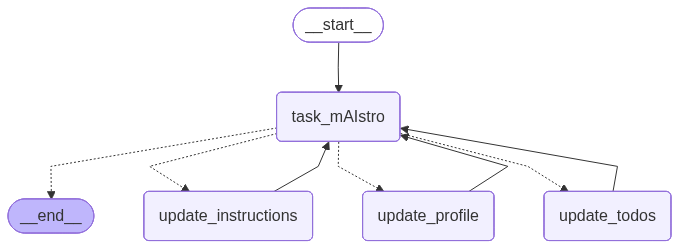

In [38]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the model
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user after a tool call was made to save memories, \
or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(
        merge_message_runs(
            messages=[
                SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)
                ] + state["messages"][:-1]
            )
        )

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) == 0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)

builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [39]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Lance. I live in SF with my wife. I have a 1 year old daughter.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (7264615e-03b1-4c7e-be45-15e724d6e980)
 Call ID: 7264615e-03b1-4c7e-be45-15e724d6e980
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Hello Lance! It's nice to meet you and learn a little about your family.


In [40]:
# User input for a ToDo
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (2c07a4cb-e599-4749-8b76-53fbc554bc15)
 Call ID: 2c07a4cb-e599-4749-8b76-53fbc554bc15
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book swim lessons for the baby', 'time_to_complete': 'TBD', 'status': 'not started'}
================================== Ai Message ==================================

I've added "Book swim lessons for the baby" to your ToDo list. I'll keep you updated on its status.


In [41]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (97b8fb8d-0af5-4cb4-b073-e407ab9c3c11)
 Call ID: 97b8fb8d-0af5-4cb4-b073-e407ab9c3c11
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Okay, Lance, I understand! You'd like me to be more proactive in suggesting local businesses or vendors when creating or updating ToDo list items. This is great feedback and will help me be more useful.

Here are your updated instructions for how to update ToDo list items:

<current_instructions>
When creating or updating ToDo list items:
1.  **Identify the core task:** Clearly state what needs to be done.
2.  **Es

In [42]:
# Check for updated instructions
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': 'Okay, Lance, I understand! You\'d like me to be more proactive in suggesting local businesses or vendors when creating or updating ToDo list items. This is great feedback and will help me be more useful.\n\nHere are your updated instructions for how to update ToDo list items:\n\n<current_instructions>\nWhen creating or updating ToDo list items:\n1.  **Identify the core task:** Clearly state what needs to be done.\n2.  **Estimate time to complete (if possible):** If the user provides context or it\'s a common task, try to estimate. Otherwise, use "TBD".\n3.  **Set initial status:** Default to "not started" for new tasks.\n4.  **Include specific local businesses/vendors:** If the ToDo item implies needing a service or product that local businesses can provide (e.g., "book swim lessons," "find a plumber," "order flowers"), actively suggest relevant local businesses or vendors. Leverage user\'s location (SF in this case) to provide relevant local suggestions.\n</current_instruc

In [50]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================

I've already added "Fix the jammed electric Yale lock on the door" to your ToDo list, and I suggested looking for a local locksmith in San Francisco. Is there anything new about this task, or would you like to add a different one?


In [28]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for 1-year-old daughter.', 'time_to_complete': 30, 'deadline': None, 'solutions': ['Check local swim schools in SF', 'Look for baby swim classes online', 'Ask friends for recommendations', 'Contact La Petite Baleen Swim School', 'Check with SF Recreation and Parks for classes'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door.', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Contact a local locksmith in SF', "Check Yale's customer support for troubleshooting", 'Look for repair guides online'], 'status': 'not started'}


In [51]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (370d650a-fed5-4de4-a861-2ec2c89fc8ef)
 Call ID: 370d650a-fed5-4de4-a861-2ec2c89fc8ef
  Args:
    update_type: todo
type of patches:  <class 'list'> [{'op': 'replace', 'value': '2025-11-30', 'path': '/deadline'}]
================================= Tool Message =================================

Document 6c5ac539-6859-473d-8bf3-d8073c1bf6bf updated:
Plan: The user wants to update the deadline for the "Book swim lessons for the baby" task to the end of November. I will update the `deadline` field of the ToDo item with the task "Book swim lessons for the baby" to "2025-11-30".
Added content: 2025-11-30
================================== Ai Message ==================================

I've updated the deadline for "Book swim lessons for the

We can see that Trustcall performs patching of the existing memory:

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r

In [52]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (54657883-d826-4dc3-b445-e2847b61946a)
 Call ID: 54657883-d826-4dc3-b445-e2847b61946a
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'status': 'not started', 'task': 'Call back City Toyota to schedule car service', 'time_to_complete': 0.0, 'solutions': ['Call City Toyota to schedule car service.']}
================================== Ai Message ==================================

I've added "Call back City Toyota to schedule car service" to your ToDo list.


In [53]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for the baby', 'time_to_complete': 0, 'deadline': '2025-11-30T00:00:00', 'solutions': ['Look for swim lessons at local places like La Petite Baleen Swim School or British Swim School in San Francisco.'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door', 'time_to_complete': 0, 'deadline': None, 'solutions': ['Look for a local locksmith in San Francisco, such as "Pop-A-Lock San Francisco" or "San Francisco Locksmith"'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door', 'time_to_complete': 0, 'deadline': None, 'solutions': ['Look for a local locksmith in San Francisco, such as "Pop-A-Lock San Francisco" or "San Francisco Locksmith"'], 'status': 'not started'}
{'task': 'Call back City Toyota to schedule car service', 'time_to_complete': 0, 'deadline': None, 'solutions': ['Call City Toyota to schedule car service.'], 'status': 'not started'}


Now we can create a new thread.

This creates a new session. 

Profile, ToDos, and Instructions saved to long-term memory are accessed. 

In [54]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

I don't have time estimates for your tasks yet, but here are the tasks on your ToDo list that you might be able to get done in 30 minutes:

*   Book swim lessons for the baby
*   Fix the jammed electric Yale lock on the door
*   Call back City Toyota to schedule car service

Would you like me to add time estimates to your ToDo list items for future reference?


In [55]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

For booking swim lessons for the baby, you could try:

*   La Petite Baleen Swim School
*   British Swim School in San Francisco


In [56]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for the baby', 'time_to_complete': 0, 'deadline': '2025-11-30T00:00:00', 'solutions': ['Look for swim lessons at local places like La Petite Baleen Swim School or British Swim School in San Francisco.'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door', 'time_to_complete': 0, 'deadline': None, 'solutions': ['Look for a local locksmith in San Francisco, such as "Pop-A-Lock San Francisco" or "San Francisco Locksmith"'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door', 'time_to_complete': 0, 'deadline': None, 'solutions': ['Look for a local locksmith in San Francisco, such as "Pop-A-Lock San Francisco" or "San Francisco Locksmith"'], 'status': 'not started'}
{'task': 'Call back City Toyota to schedule car service', 'time_to_complete': 0, 'deadline': None, 'solutions': ['Call City Toyota to schedule car service.'], 'status': 'not started'}


In [58]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': 'Okay, Lance, I understand! You\'d like me to be more proactive in suggesting local businesses or vendors when creating or updating ToDo list items. This is great feedback and will help me be more useful.\n\nHere are your updated instructions for how to update ToDo list items:\n\n<current_instructions>\nWhen creating or updating ToDo list items:\n1.  **Identify the core task:** Clearly state what needs to be done.\n2.  **Estimate time to complete (if possible):** If the user provides context or it\'s a common task, try to estimate. Otherwise, use "TBD".\n3.  **Set initial status:** Default to "not started" for new tasks.\n4.  **Include specific local businesses/vendors:** If the ToDo item implies needing a service or product that local businesses can provide (e.g., "book swim lessons," "find a plumber," "order flowers"), actively suggest relevant local businesses or vendors. Leverage user\'s location (SF in this case) to provide relevant local suggestions.\n</current_instruc

In [67]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)

{'name': 'Lance', 'location': 'SF', 'job': None, 'connections': ['wife', '1 year old daughter'], 'interests': []}


In [68]:
across_thread_memory.__dir__()


['__module__',
 '__firstlineno__',
 '__doc__',
 '__slots__',
 '__init__',
 'batch',
 'abatch',
 '_filter_items',
 '_embed_search_queries',
 '_aembed_search_queries',
 '_batch_search',
 '_prepare_ops',
 '_apply_put_ops',
 '_extract_texts',
 '_insertinmem_store',
 '_handle_list_namespaces',
 '__static_attributes__',
 '_data',
 '_vectors',
 'embeddings',
 'index_config',
 '__abstractmethods__',
 '_abc_impl',
 '__annotations__',
 'supports_ttl',
 'ttl_config',
 'get',
 'search',
 'put',
 'delete',
 'list_namespaces',
 'aget',
 'asearch',
 'aput',
 'adelete',
 'alist_namespaces',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [69]:
across_thread_memory.list_namespaces()

[('instructions', 'Lance'), ('profile', 'Lance'), ('todo', 'Lance')]

Trace: 

https://smith.langchain.com/public/84768705-be91-43e4-8a6f-f9d3cee93782/r

## Studio

![Screenshot 2024-11-04 at 1.00.19 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732cfb05d9709862eba4e6c_Screenshot%202024-11-11%20at%207.46.40%E2%80%AFPM.png)